# GeoTIFF
Generating virutal datasets from GeoTiff files

<img src="../images/radar.png" width=400 alt="ARG"></img>

## Overview

In this tutorial we will cover:

1. How to generate virtual datasets from GeoTIFFs.
1. Combining virtual datasets.


## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Basics of virtual Zarr stores](../foundations/01_kerchunk_basics.ipynb) | Required | Core |
| [Multi-file virtual datasets with VirtualiZarr](../foundations/02_kerchunk_multi_file.ipynb) | Required | Core |
| [Parallel virtual dataset creation with VirtualiZarr, Kerchunk, and Dask](../foundations/03_kerchunk_dask) | Required | Core |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Required | IO/Visualization |
- **Time to learn**: 30 minutes
---

## About the Dataset

The Finish Meterological Institute (FMI) Weather Radar Dataset is a collection of GeoTIFF files containing multiple radar specific variables, such as rainfall intensity, precipitation accumulation (in 1, 12 and 24 hour increments),  radar reflectivity, radial velocity, rain classification and the cloud top height. It is available through the [AWS public data portal](https://aws.amazon.com/marketplace/pp/prodview-koodet467asui?sr=0-19&ref_=beagle&applicationId=AWSMPContessa) and is updated frequently. 



More details on this dataset can be found [here](https://en.ilmatieteenlaitos.fi/radar-data-on-aws-s3).


In [1]:
import logging
from datetime import datetime

import dask
import fsspec
import rioxarray
import s3fs
import xarray as xr
from distributed import Client
from virtualizarr import open_virtual_dataset

### Examining a Single GeoTIFF File

Before we use `Kerchunk` to create indices for multiple files, we can load a single GeoTiff file to examine it. 


In [2]:
# URL pointing to a single GeoTIFF file
url = "s3://fmi-opendata-radar-geotiff/2023/07/01/FIN-ACRR-3067-1KM/202307010100_FIN-ACRR1H-3067-1KM.tif"

# Initialize a s3 filesystem
fs = s3fs.S3FileSystem(anon=True)

xds = rioxarray.open_rasterio(fs.open(url))

In [3]:
xds

<xarray.DataArray (band: 1, y: 1345, x: 850)> Size: 2MB
[1143250 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB -1.177e+05 -1.166e+05 ... 8.738e+05 8.75e+05
  * y            (y) float64 11kB 7.907e+06 7.906e+06 ... 6.337e+06 6.336e+06
    spatial_ref  int64 8B 0
Attributes:
    GDAL_METADATA:  <GDALMetadata>\n<Item name="Observation time" format="YYY...
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

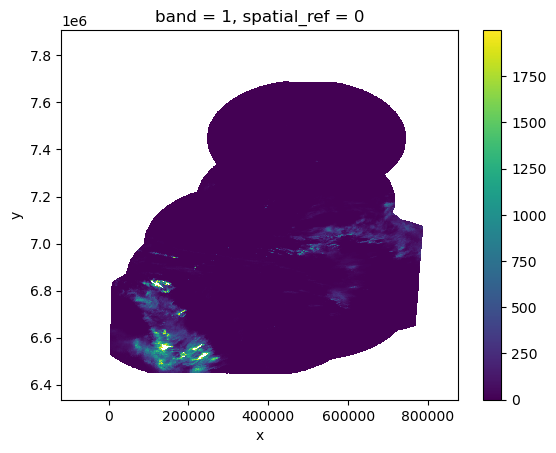

In [4]:
xds.isel(band=0).where(xds < 2000).plot()

## Create Input File List

Here we are using `fsspec's` glob functionality along with the *`*`* wildcard operator and some string slicing to grab a list of GeoTIFF files from a `s3` `fsspec` filesystem. 

In [5]:
# Initiate fsspec filesystems for reading
fs_read = fsspec.filesystem("s3", anon=True, skip_instance_cache=True)

files_paths = fs_read.glob(
    "s3://fmi-opendata-radar-geotiff/2023/01/01/FIN-ACRR-3067-1KM/*24H-3067-1KM.tif"
)
# Here we prepend the prefix 's3://', which points to AWS.
files_paths = sorted(["s3://" + f for f in files_paths])

## Start a Dask Client

To parallelize the creation of our reference files, we will use `Dask`. For a detailed guide on how to use Dask and Kerchunk, see the Foundations notebook: [Kerchunk and Dask](../foundations/kerchunk_dask).


In [6]:
client = Client(n_workers=8, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/maxrjones/virtualizarr/proxy/8787/status,
Dashboard: /user/maxrjones/virtualizarr/proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43057,Workers: 8
Dashboard: /user/maxrjones/virtualizarr/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:37295,Total threads: 1
Dashboard: /user/maxrjones/virtualizarr/proxy/42683/status,Memory: 1.85 GiB
Nanny: tcp://127.0.0.1:41433,


In [7]:
def generate_virtual_dataset(file):
    vds = open_virtual_dataset(
        file,
        indexes={},
        filetype="tiff",
        reader_options={"remote_options": {"anon": True}},
    )
    # Pre-process virtual datasets to extract time step information from the filename
    subst = file.split("/")[-1].split(".json")[0].split("_")[0]
    time_val = datetime.strptime(subst, "%Y%m%d%H%M")
    vds = vds.expand_dims(dim={"time": [time_val]})
    # Only include the raw data, not the overviews
    vds = vds[["0"]]
    return vds

In [8]:
# Generate Dask Delayed objects
tasks = [dask.delayed(generate_virtual_dataset)(file) for file in files_paths]

In [9]:
# Start parallel processing
import warnings

warnings.filterwarnings("ignore")
virtual_datasets = dask.compute(*tasks)

/opt/conda/lib/python3.11/site-packages/virtualizarr/readers/tiff.py:41: UserWarning: storage_options have been dropped from reader_options as they are not supported by kerchunk.tiff.tiff_to_zarr
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/virtualizarr/readers/tiff.py:41: UserWarning: storage_options have been dropped from reader_options as they are not supported by kerchunk.tiff.tiff_to_zarr
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/virtualizarr/readers/tiff.py:41: UserWarning: storage_options have been dropped from reader_options as they are not supported by kerchunk.tiff.tiff_to_zarr
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/virtualizarr/readers/tiff.py:41: UserWarning: storage_options have been dropped from reader_options as they are not supported by kerchunk.tiff.tiff_to_zarr
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/virtualizarr/readers/tiff.py:41: UserWarning: storage_options have been dropped from reader_options as they 

## Combine virtual datasets

In [10]:
combined_vds = xr.concat(virtual_datasets, dim="time")
combined_vds

<xarray.Dataset> Size: 53MB
Dimensions:  (time: 23, Y: 1345, X: 850)
Coordinates:
  * time     (time) datetime64[ns] 184B 2023-01-01T01:00:00 ... 2023-01-01T23...
Dimensions without coordinates: Y, X
Data variables:
    0        (time, Y, X) uint16 53MB ManifestArray<shape=(23, 1345, 850), dt...
Attributes: (12/15)
    multiscales:             [{'datasets': [{'path': '0'}, {'path': '1'}, {'p...
    GDAL_METADATA:           &lt;GDALMetadata&gt;\n&lt;Item name=&quot;Observ...
    KeyDirectoryVersion:     1
    KeyRevision:             1
    KeyRevisionMinor:        0
    GTModelTypeGeoKey:       1
    ...                      ...
    GeogAngularUnitsGeoKey:  9102
    GeogTOWGS84GeoKey:       [0.0, 0.0, 0.0]
    ProjectedCSTypeGeoKey:   3067
    ProjLinearUnitsGeoKey:   9001
    ModelPixelScale:         [1169.2930568410832, 1168.8701637541064, 0.0]
    ModelTiepoint:           [0.0, 0.0, 0.0, -118331.36640835612, 7907751.537...

## Shut down the Dask cluster

In [11]:
client.shutdown()